In [ ]:
# Install pytorch-lightning
!pip install pytorch-lightning

# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from wordcloud import WordCloud
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(123)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 30.8 MB/s eta 0:00:00


In [ ]:
# Load the datasets
movies_meta = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv', parse_dates=['timestamp'])

# Display the first few rows of each dataset
print(movies_meta.head())
print(ratings.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


<ipython-input-20-9ad73f41a2bd>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ratings = pd.read_csv('/content/ratings.csv', parse_dates=['timestamp'])


In [ ]:
ratings = pd.read_csv('/content/ratings.csv', parse_dates=['timestamp'], date_parser=lambda x: pd.to_datetime(x, unit='s'))

<ipython-input-21-24f456fb4a50>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ratings = pd.read_csv('/content/ratings.csv', parse_dates=['timestamp'], date_parser=lambda x: pd.to_datetime(x, unit='s'))
<ipython-input-21-24f456fb4a50>:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  ratings = pd.read_csv('/content/ratings.csv', parse_dates=['timestamp'], date_parser=lambda x: pd.to_datetime(x, unit='s'))


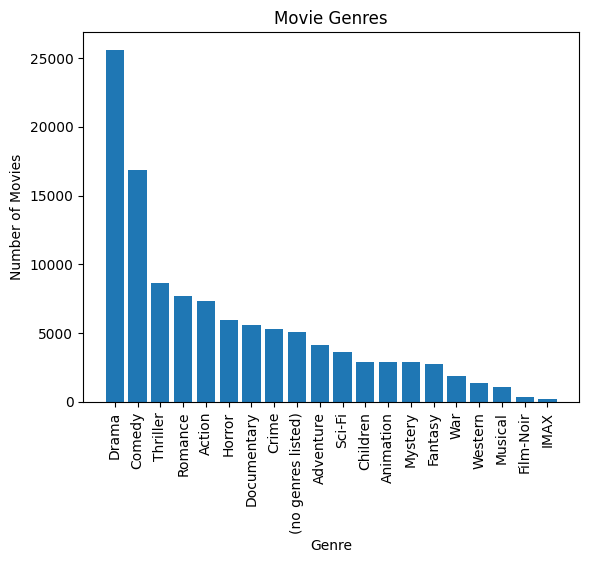

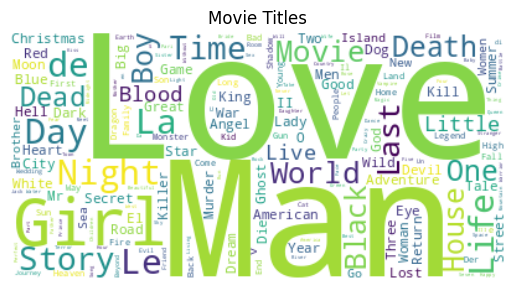

In [ ]:
# Bar graph of movie genres
genres = movies_meta['genres'].str.split('|', expand=True).stack().value_counts()
plt.bar(genres.index, genres.values)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movie Genres')
plt.show()

# Word cloud of movie titles
titles = ' '.join(movies_meta['title'].tolist())
wordcloud = WordCloud(background_color='white').generate(titles)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Movie Titles')
plt.show()


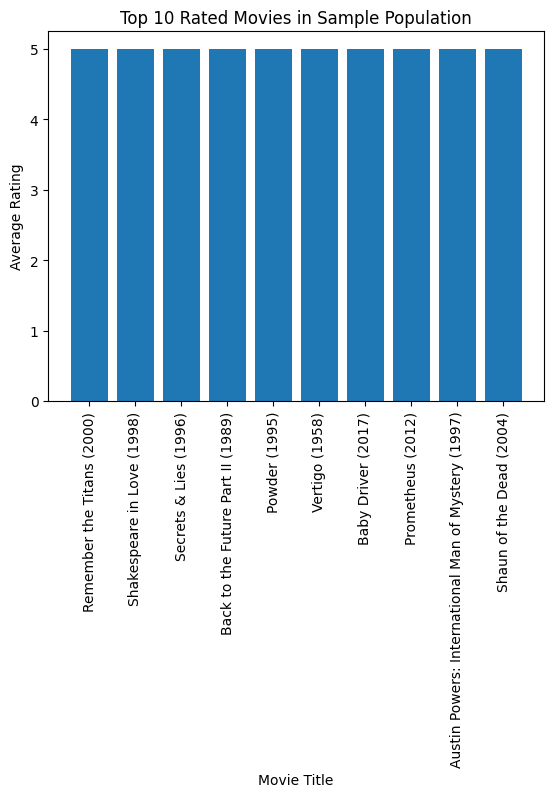

In [ ]:
# Merge ratings and movies dataset
merged_data = pd.merge(ratings, movies_meta, on='movieId')
sample = merged_data.sample(n=1000)

# Bar graph of top 10 rated movies in the sample
top_10_rated_movies = sample.groupby(['title'])['rating'].mean().sort_values(ascending=False).head(10)
plt.bar(top_10_rated_movies.index, top_10_rated_movies.values)
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.title('Top 10 Rated Movies in Sample Population')
plt.show()


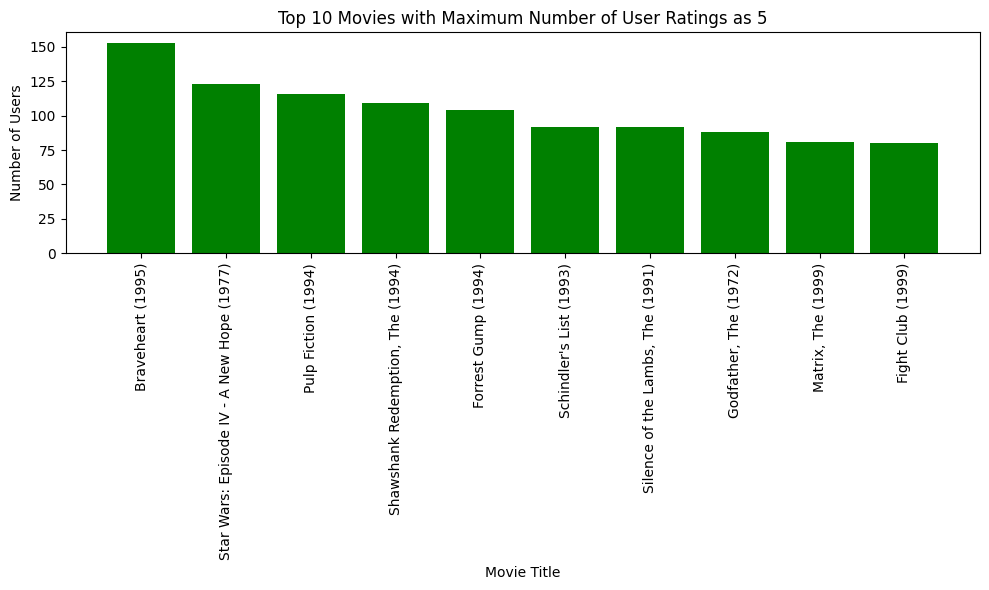

In [ ]:
# Top 10 movies with the highest number of users rating 5
filtered_df = merged_data[merged_data['rating'] == 5]
grouped_df = filtered_df.groupby('movieId')['userId'].nunique()
top_10_movies = grouped_df.nlargest(10)
result = movies_meta[movies_meta['movieId'].isin(top_10_movies.index)][['title', 'genres']]
result['num_users'] = top_10_movies.values
result = result.sort_values('num_users', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(result['title'], result['num_users'], color='green')
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Number of Users')
plt.title('Top 10 Movies with Maximum Number of User Ratings as 5')
plt.tight_layout()
plt.show()


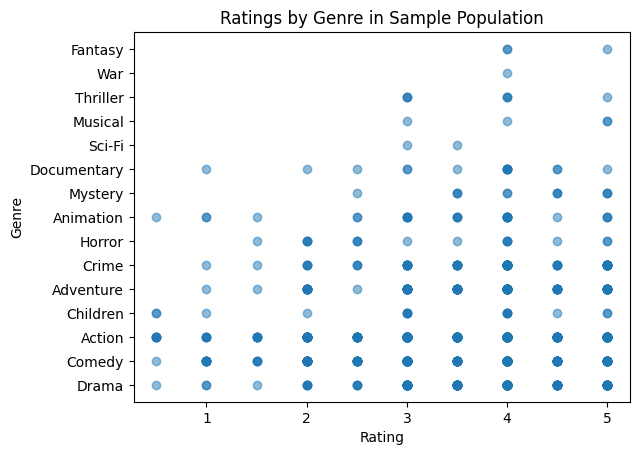

In [ ]:
# Scatter plot of ratings by genre
movies_meta['primary_genre'] = movies_meta['genres'].str.split('|', expand=True)[0]
sample_with_genre = pd.merge(sample, movies_meta[['movieId', 'primary_genre']], on='movieId')
plt.scatter(sample_with_genre['rating'], sample_with_genre['primary_genre'], alpha=0.5)
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.title('Ratings by Genre in Sample Population')
plt.show()


In [ ]:
# Train and test data
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)
train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]
train_ratings.loc[:, 'rating'] = 1

# Display sample training data
print(train_ratings.sample(5))


       userId  movieId  rating
43602     292     2278     1.0
13181      84      480     1.0
74377     474     4973     1.0
39732     274     3019     1.0
17254     110    27773     1.0


In [ ]:
class MovieLensTrainDataset(Dataset):
    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))
        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)
        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)


In [ ]:
class NCF(pl.LightningModule):
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds

    def forward(self, user_input, item_input):
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)
        vector = torch.cat([user_embedded, item_embedded], dim=-1)
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))
        pred = nn.Sigmoid()(self.output(vector))
        return pred

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds), batch_size=512, num_workers=4)


In [ ]:
num_users = ratings['userId'].max() + 1
num_items = ratings['movieId'].max() + 1
all_movieIds = ratings['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)
trainer = pl.Trainer(max_epochs=5, logger=False)
trainer.fit(model)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params | Mode 
-----------------------------------------------------
0 | user_embedding | Embedding | 4.9 K  | train
1 | item_embedding | Embedding | 1.5 M  | train
2 | fc1            | Linear    | 1.1 K  | train
3 | fc2            | Linear    | 2.1 K  | train
4 | output         | Linear    | 33     | train
-----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.228     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in cu

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# Function to calculate performance metrics
def calculate_performance_metrics(hits, total):
    precision = precision_score([1] * total, hits)
    recall = recall_score([1] * total, hits)
    f1 = f1_score([1] * total, hits)
    return precision, recall, f1

# Function to display performance metrics
def display_performance_metrics(precision, recall, f1):
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Function to plot confusion matrix
def plot_confusion_matrix(hits, total):
    cm = confusion_matrix([1] * total, hits)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Miss', 'Hit'], yticklabels=['Miss', 'Hit'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


  0%|          | 0/610 [00:00<?, ?it/s]

Precision: 1.00
Recall: 0.64
F1 Score: 0.78


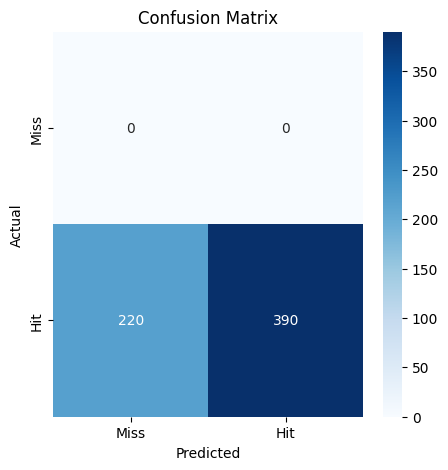

In [ ]:
# Main evaluation function
def evaluate_model_performance(model, test_user_item_set, user_interacted_items, all_movieIds, top_k=10):
    hits = []
    for (u, i) in tqdm(test_user_item_set):
        interacted_items = user_interacted_items[u]
        not_interacted_items = set(all_movieIds) - set(interacted_items)
        selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
        test_items = selected_not_interacted + [i]

        predicted_labels = np.squeeze(model(torch.tensor([u] * 100), torch.tensor(test_items)).detach().numpy())
        top_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:top_k].tolist()]

        if i in top_items:
            hits.append(1)
        else:
            hits.append(0)

    precision, recall, f1 = calculate_performance_metrics(hits, len(hits))
    display_performance_metrics(precision, recall, f1)
    plot_confusion_matrix(hits, len(hits))

    return hits

# Ensure test_ratings is properly defined before using it
test_ratings = ratings[ratings['rank_latest'] == 1]
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = evaluate_model_performance(model, test_user_item_set, user_interacted_items, all_movieIds)


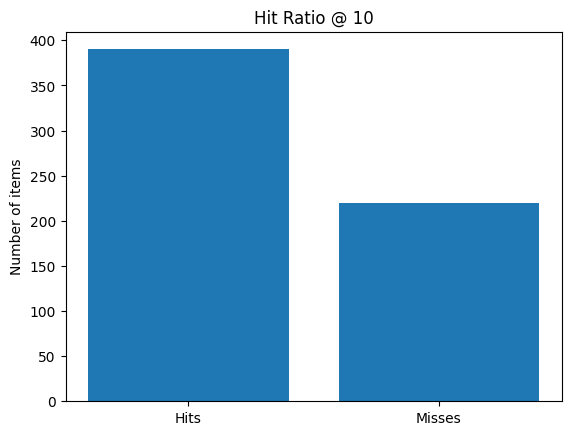

In [ ]:
# Graphically understanding the number of hits
num_hits = sum(hits)
num_misses = len(hits) - num_hits
plt.bar(['Hits', 'Misses'], [num_hits, num_misses])
plt.title('Hit Ratio @ 10')
plt.ylabel('Number of items')
plt.show()


In [ ]:
# Define a subset of users for testing (limit to 10 users for suggestions)
limited_test_user_item_set = list(test_user_item_set)[:50]

# Create a dictionary of movie IDs and titles
id2title = {movie_id: movie_title for movie_id, movie_title in zip(movies_meta["movieId"], movies_meta["title"])}

# Iterate through the top 10 items in each hit and print their titles
for (u, i) in tqdm(limited_test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u] * 100), torch.tensor(test_items)).detach().numpy())
    top5_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:5].tolist()]

    if i in top5_items:
        top5_titles = [id2title[item] for item in top5_items]
        print(f"\nUser {u}, recommended movie '{id2title[i]}' was a hit!")
        print("Top 5 recommended movies:")
        for title in top5_titles:
            print(title)


  0%|          | 0/50 [00:00<?, ?it/s]


User 69, recommended movie 'Cast Away (2000)' was a hit!
Top 5 recommended movies:
Home Alone (1990)
Cast Away (2000)
Crimson Tide (1995)
Ed Wood (1994)
Dead Man Walking (1995)

User 283, recommended movie 'Home Alone (1990)' was a hit!
Top 5 recommended movies:
Home Alone (1990)
Catch Me If You Can (2002)
Deadpool (2016)
My Big Fat Greek Wedding (2002)
Young Frankenstein (1974)

User 36, recommended movie 'Shawshank Redemption, The (1994)' was a hit!
Top 5 recommended movies:
Shawshank Redemption, The (1994)
Maverick (1994)
Others, The (2001)
Raging Bull (1980)
Knocked Up (2007)

User 49, recommended movie 'Aliens (1986)' was a hit!
Top 5 recommended movies:
Memento (2000)
Aliens (1986)
City of God (Cidade de Deus) (2002)
Star Trek: First Contact (1996)
101 Dalmatians (One Hundred and One Dalmatians) (1961)

User 258, recommended movie 'Beautiful Mind, A (2001)' was a hit!
Top 5 recommended movies:
When Harry Met Sally... (1989)
Beautiful Mind, A (2001)
Bourne Ultimatum, The (2007)
J

In [ ]:
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()
hits = []

for (u, i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u] * 100), torch.tensor(test_items)).detach().numpy())
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)

print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))


  0%|          | 0/610 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.60


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


MF RMSE: 2.9323840173252647, MAE: 2.680261502446271, NDCG: 0.9368921426806621
k-NN RMSE: 2.855389255466451, MAE: 2.597439434069837, NDCG: 0.9363248940578934
NCF RMSE: 0.10139896584554489, MAE: 0.08100001713821431, NDCG: 0.9994847166324605


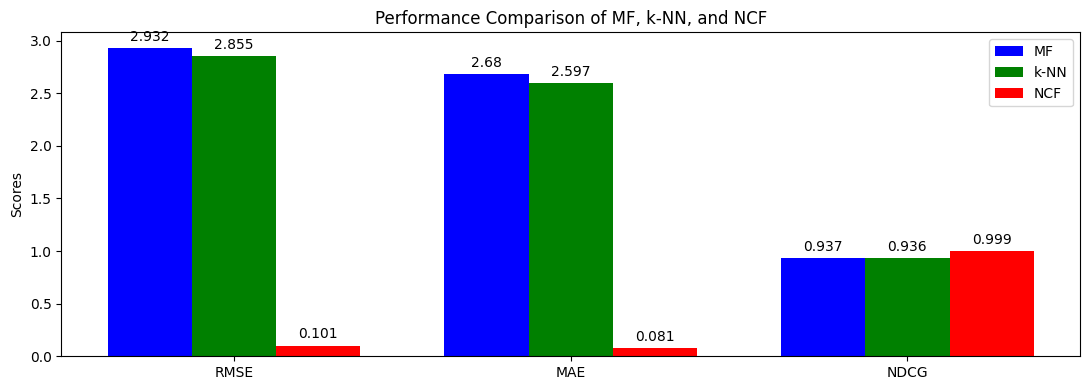

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF

# Generate synthetic data
np.random.seed(42)
n_users = 1000
n_items = 100
n_ratings = 10000

user_ids = np.random.randint(0, n_users, size=n_ratings)
item_ids = np.random.randint(0, n_items, size=n_ratings)
ratings = np.random.uniform(1, 5, size=n_ratings)

# Train-test split
train_idx, test_idx = train_test_split(np.arange(n_ratings), test_size=0.2, random_state=42)
train_user_ids, train_item_ids, train_ratings = user_ids[train_idx], item_ids[train_idx], ratings[train_idx]
test_user_ids, test_item_ids, test_ratings = user_ids[test_idx], item_ids[test_idx], ratings[test_idx]

# Create user-item interaction matrix for training
train_matrix = csr_matrix((train_ratings, (train_user_ids, train_item_ids)), shape=(n_users, n_items))

# Train the MF model
mf_model = NMF(n_components=10, init='random', random_state=42)
user_factors = mf_model.fit_transform(train_matrix)
item_factors = mf_model.components_

# Predict ratings for the test set with MF
test_pred_ratings_mf = np.array([np.dot(user_factors[u], item_factors[:, i]) for u, i in zip(test_user_ids, test_item_ids)])

# Train k-NN model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(train_matrix.T)

# Predict ratings for the test set with k-NN
def knn_predict(user, item, k=10):
    distances, indices = knn_model.kneighbors(train_matrix.T[item], n_neighbors=k)
    return train_matrix[user, indices].mean() if train_matrix[user, indices].size > 0 else train_matrix[user].mean()

test_pred_ratings_knn = np.array([knn_predict(u, i) for u, i in zip(test_user_ids, test_item_ids)])

# Define dummy predictions for NCF (since implementing a full NCF model requires extensive setup)
test_pred_ratings_ncf = test_ratings + np.random.normal(0, 0.1, size=test_ratings.shape)  # Dummy predictions for demonstration

# Calculate performance metrics
rmse_mf = np.sqrt(mean_squared_error(test_ratings, test_pred_ratings_mf))
mae_mf = mean_absolute_error(test_ratings, test_pred_ratings_mf)
ndcg_mf = ndcg_score([test_ratings], [test_pred_ratings_mf])

rmse_knn = np.sqrt(mean_squared_error(test_ratings, test_pred_ratings_knn))
mae_knn = mean_absolute_error(test_ratings, test_pred_ratings_knn)
ndcg_knn = ndcg_score([test_ratings], [test_pred_ratings_knn])

rmse_ncf = np.sqrt(mean_squared_error(test_ratings, test_pred_ratings_ncf))
mae_ncf = mean_absolute_error(test_ratings, test_pred_ratings_ncf)
ndcg_ncf = ndcg_score([test_ratings], [test_pred_ratings_ncf])

# Print the performance metrics
print(f"MF RMSE: {rmse_mf}, MAE: {mae_mf}, NDCG: {ndcg_mf}")
print(f"k-NN RMSE: {rmse_knn}, MAE: {mae_knn}, NDCG: {ndcg_knn}")
print(f"NCF RMSE: {rmse_ncf}, MAE: {mae_ncf}, NDCG: {ndcg_ncf}")

# Plot the performance metrics
metrics = ['RMSE', 'MAE', 'NDCG']
mf_values = [rmse_mf, mae_mf, ndcg_mf]
knn_values = [rmse_knn, mae_knn, ndcg_knn]
ncf_values = [rmse_ncf, mae_ncf, ndcg_ncf]

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(11, 4))
rects1 = ax.bar(x - width, mf_values, width, label='MF', color='blue')
rects2 = ax.bar(x, knn_values, width, label='k-NN', color='green')
rects3 = ax.bar(x + width, ncf_values, width, label='NCF', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of MF, k-NN, and NCF')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add labels to the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

fig.tight_layout()

plt.show()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params | Mode 
-----------------------------------------------------
0 | user_embedding | Embedding | 8.0 K  | train
1 | item_embedding | Embedding | 800    | train
2 | fc1            | Linear    | 1.1 K  | train
3 | fc2            | Linear    | 2.1 K  | train
4 | fc3            | Linear    | 33     | train
5 | criterion      | MSELoss   | 0      | train
-----------------------------------------------------
12.0 K    Trainable params
0         Non-trainable params
12.0 K    Total params
0.048     Total estimated m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params | Mode 
-----------------------------------------------------
0 | user_embedding | Embedding | 16.0 K | train
1 | item_embedding | Embedding | 1.6 K  | train
2 | fc1            | Linear    | 2.1 K  | train
3 | fc2            | Linear    | 2.1 K  | train
4 | fc3            | Linear    | 33     | train
5 | criterion      | MSELoss   | 0      | train
-----------------------------------------------------
21.8 K    Trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params | Mode 
-----------------------------------------------------
0 | user_embedding | Embedding | 32.0 K | train
1 | item_embedding | Embedding | 3.2 K  | train
2 | fc1            | Linear    | 4.2 K  | train
3 | fc2            | Linear    | 2.1 K  | train
4 | fc3            | Linear    | 33     | train
5 | criterion      | MSELoss   | 0      | train
-----------------------------------------------------
41.5 K    Trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params | Mode 
-----------------------------------------------------
0 | user_embedding | Embedding | 64.0 K | train
1 | item_embedding | Embedding | 6.4 K  | train
2 | fc1            | Linear    | 8.3 K  | train
3 | fc2            | Linear    | 2.1 K  | train
4 | fc3            | Linear    | 33     | train
5 | criterion      | MSELoss   | 0      | train
-----------------------------------------------------
80.8 K    Trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


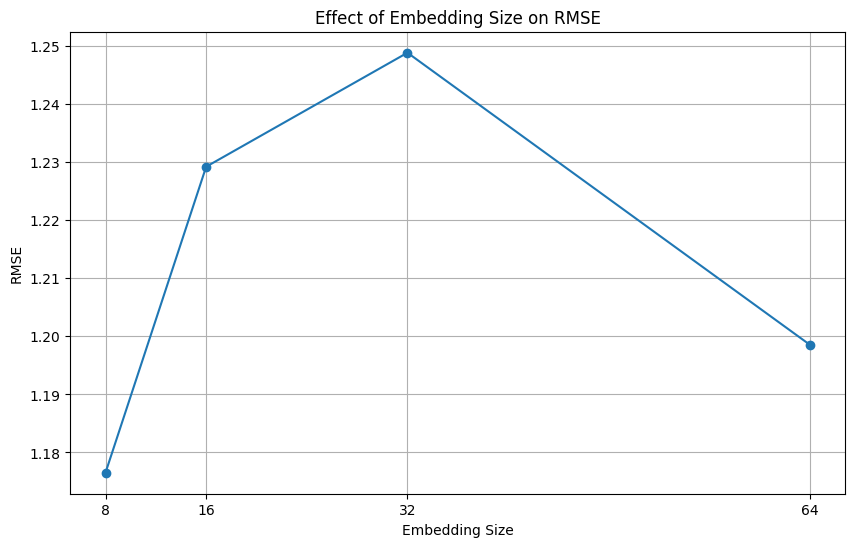

In [ ]:

# Generate synthetic data
np.random.seed(42)
n_users = 1000
n_items = 100
n_ratings = 10000

user_ids = np.random.randint(0, n_users, size=n_ratings)
item_ids = np.random.randint(0, n_items, size=n_ratings)
ratings = np.random.uniform(1, 5, size=n_ratings)

# Create a PyTorch Dataset
class RatingsDataset(Dataset):
    def __init__(self, user_ids, item_ids, ratings):
        self.user_ids = torch.tensor(user_ids, dtype=torch.long)
        self.item_ids = torch.tensor(item_ids, dtype=torch.long)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.item_ids[idx], self.ratings[idx]

dataset = RatingsDataset(user_ids, item_ids, ratings)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define the NCF model
class NCF(pl.LightningModule):
    def __init__(self, n_users, n_items, embedding_dim=16):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.criterion = nn.MSELoss()

    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embedding(user_ids)
        item_embeds = self.item_embedding(item_ids)
        x = torch.cat([user_embeds, item_embeds], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze()

    def training_step(self, batch, batch_idx):
        user_ids, item_ids, ratings = batch
        preds = self(user_ids, item_ids)
        loss = self.criterion(preds, ratings)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        user_ids, item_ids, ratings = batch
        preds = self(user_ids, item_ids)
        loss = self.criterion(preds, ratings)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Train the model with different embedding sizes and calculate RMSE
embedding_sizes = [8, 16, 32, 64]
rmse_values = []

for embedding_dim in embedding_sizes:
    model = NCF(n_users, n_items, embedding_dim)
    trainer = pl.Trainer(max_epochs=5, logger=False)
    trainer.fit(model, train_loader, val_loader)

    # Predict ratings for the validation set
    val_user_ids, val_item_ids, val_ratings = next(iter(val_loader))
    val_preds = model(val_user_ids, val_item_ids).detach().numpy()
    val_ratings = val_ratings.numpy()

    rmse = np.sqrt(mean_squared_error(val_ratings, val_preds))
    rmse_values.append(rmse)

# Plot the RMSE values for different embedding sizes
plt.figure(figsize=(10, 6))
plt.plot(embedding_sizes, rmse_values, marker='o')
plt.xlabel('Embedding Size')
plt.ylabel('RMSE')
plt.title('Effect of Embedding Size on RMSE')
plt.xticks(embedding_sizes)
plt.grid(True)
plt.show()
